In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import fredapi as fa
import requests
import json
import prettytable
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
fred = fa.Fred("e9dded667e8d26a2ac0ea819620521dc")


In [3]:
class MacroFactors:
    
    fred = fa.Fred("e9dded667e8d26a2ac0ea819620521dc")
    
    def __init__(self) -> None:
        self.dict_factors = {}
        
        #method calls
        CCI = self.consumer_confidence_index()
        JC = self.jobless_claims()
        DGO = self.durable_goods_orders()
        GDP = self.GDP()
        CPI = self.CPI()
        inflation = self.inflation(CPI, 12)
        employment_number = self.employment()
        unemployment_rate = self.unemployment_rate()
        interest_rates = self.interest_rates()
        retail_sales = self.retail_sales
        PCE = self.PCE()
        existing_home_sales = self.existing_home_sales()
        self.excel_writer(self.dict_factors)
    
    def get_FRED_data(self, str_factor):
        '''
        Code used to retrieve data from the FED.
        '''
        if type(str_factor) == str:
            series_factor = fred.get_series(str_factor)
            return series_factor
        else:
            raise TypeError("The input for the macroeconomic factor should be a string")

    def period_to_month(self, column):
    # Turns the month values into numbers that can be understood by pandas
        if column == "M01":
            column = 1
        if column == "M02":
            column = 2
        if column == "M03":
            column = 3
        if column == "M04":
            column = 4
        if column == "M05":
            column = 5
        if column == "M06":
            column = 6
        if column == "M07":
            column = 7
        if column == "M08":
            column = 8
        if column == "M09":
            column = 9
        if column == "M10":
            column = 10
        if column == "M11":
            column = 11
        if column == "M12":
            column = 12
        
        return column

    def get_BofL_data(self, str_factor, str_ID, str_start_year, str_end_year): 
        """
        Code used to access the Bureau of Labor Statistics API.
        Converts the data into a dataframe.
        """
        
        if isinstance(str_factor, str) and isinstance(str_ID, str) and isinstance(str_start_year, str) and isinstance(str_end_year, str):
            headers = {'Content-type': 'application/json'}
            data = json.dumps({"seriesid": [str_ID], "startyear": str_start_year, "endyear":str_end_year, "registrationkey": "38cbbfb1038446378c6e795256489334"})
            p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
            json_data = json.loads(p.text)
            
            for series in json_data['Results']['series']:
                x = prettytable.PrettyTable(["series id","year","period","value","footnotes"])
                seriesId = series['seriesID']
                for item in series['data']:
                    year = item['year']
                    period = item['period']
                    value = item['value']
                    footnotes=""
                    for footnote in item['footnotes']:
                        if footnote:
                            footnotes = footnotes + footnote['text'] + ','
                    if 'M01' <= period <= 'M12':
                        x.add_row([seriesId,year,period,value,footnotes[0:-1]])

            x_as_csv = x.get_csv_string().replace('\r','')
            text_file = open(f"{str_factor}.csv", "w")
            n = text_file.write(x_as_csv)
            text_file.close()
            df_x = pd.read_csv(f"{str_factor}.csv")
            df_factor = df_x.loc[::-1].reset_index(drop=True)
            df_factor["month"] = df_factor["period"].apply(self.period_to_month)
            df_factor = df_factor.assign(Date=pd.to_datetime(df_factor[['year', 'month']].assign(day=1)))
            
            return df_factor
            
        else:
            raise TypeError("All inputs must be strings")
        
    def plot_factor(self, series_factor):
        p = plt.plot(series_factor.index, series_factor.values)
        return p
        
    #Leading factors
    def consumer_confidence_index(self):
        """
        Get FRED data on consumer confidence index
        This number will be delayed by a Month due to data not being available to the public
        """
        series_cci = (self.get_FRED_data('UMCSENT')).dropna()
        self.dict_factors['CCI'] = series_cci
        display(f"The most recent calculation of the CCI in the US is {series_cci[-1]}")
        self.plot_factor(series_cci)
        return series_cci
    
    def jobless_claims(self):
        """
        Get FRED data on the number of jobless claims
        This number will be delayed by a Month due to data not being available to the public
        """
        series_jc = (self.get_FRED_data('ICSA')).dropna()
        self.dict_factors['Jobless Claims'] = series_jc
        display(f"The most recent calculation of the weekly number of jobless claims in the US is {series_jc[-1]}")
        self.plot_factor(series_jc)
        return series_jc
        
    def durable_goods_orders(self):
        """
        Get FRED data on the number of jobless claims
        This number will be delayed by a Month due to data not being available to the public
        """
        series_dgo = (self.get_FRED_data('DGORDER')).dropna()
        self.dict_factors['Durable Goods Orders'] = series_dgo
        display(f"The most recent calculation of the number of durable goods order in the US is {series_dgo[-1]}")
        self.plot_factor(series_dgo)
        return series_dgo
    
    #Lagging factors
    def GDP(self):
        """
        Get FRED data on real GDP
        This number will be delayed by a Month due to data not being available to the public
        """
        series_gdp = (self.get_FRED_data('GDP')).dropna()
        self.dict_factors['GDP'] = series_gdp
        display(f"The most recent calculation of the GDP in the US is ${series_gdp[-1]*1000000000}")
        self.plot_factor(series_gdp)
        return series_gdp
    
    def CPI(self):
        """
        Get Bureau of Labor Statistics data on CPI
        This number will be delayed by a Month due to data not being available to the public
        """
        df_CPI = (self.get_BofL_data('CPI','CUUR0000SA0', '2004', '2023'))
        df_CPI = df_CPI[["value", "Date"]] 
        series_CPI = df_CPI.set_index("Date")        
        self.dict_factors["CPI"] = df_CPI
        display(f"The most recent calculation of the CPI in the US for all Urban Consumers is {float(series_CPI.iloc[-1])}")
        self.plot_factor(series_CPI)
        return series_CPI

    def inflation(self, series_CPI, time):
        inflation = float(((series_CPI.iloc[-1] - series_CPI.iloc[-(time+1)])) /series_CPI.iloc[-13] * 100)
        display(f"The inflation calculated from the CPI for the last {time} months is {round(inflation,3)} %")
        return inflation
        
    def employment(self):
        """
        Get Bureau of Labor Statistics data on seasonally adjusted employment
        """
        df_employment_rate = (self.get_BofL_data('Employment Rate', 'LNS12000000', '2005', '2023'))
        df_employment_rate = df_employment_rate[["value", "Date"]] 
        series_employment_rate = df_employment_rate.set_index("Date")        
        self.dict_factors["CPI"] = df_employment_rate
        display(f"The most recent calculation of the employment numbers in the US is {float(series_employment_rate.iloc[-1])}")
        self.plot_factor(series_employment_rate)
    
    def unemployment_rate(self):
        """
        Get Bureau of Labor Statistics data on seasonally adjusted unemployment rate
        """
        df_unemployment_rate = (self.get_BofL_data('Unemployment Rate', 'LNS14000000', '2005', '2023'))
        df_unemployment_rate = df_unemployment_rate[["value", "Date"]] 
        series_unemployment_rate = df_unemployment_rate.set_index("Date")        
        self.dict_factors["CPI"] = df_unemployment_rate
        display(f"The most recent calculation of the unemployment rate in is {float(series_unemployment_rate.iloc[-1])}")
        self.plot_factor(series_unemployment_rate)
        return series_unemployment_rate
    
    #Needs work prob use the yield curve here
    def interest_rates(self):
        """Get FRED data on the Treasury Yield Curve of the 10 year minus 2 Year Treasury Constant Maturity"""
        series_yield_curve = (self.get_FRED_data('T10Y2Y')).dropna()
        self.dict_factors["Yield Curve"] = series_yield_curve
        display(f"The most recent calculation of the 10 Year - 2 Year T Bill Maturity is {(series_yield_curve[-1])}")
        self.plot_factor(series_yield_curve)
        return series_yield_curve
    
    def interest_rates(self):
        """Get FRED data on the Treasury Yield Curve of the 10 year minus 2 Year Treasury Constant Maturity"""
        series_yield_curve = (self.get_FRED_data('T10Y2Y')).dropna()
        self.dict_factors["Yield Curve"] = series_yield_curve
        display(f"The most recent calculation of the 10 Year - 2 Year T Bill Maturity is {(series_yield_curve[-1])}")
        self.plot_factor(series_yield_curve)
        return series_yield_curve
    
    def interest_rates(self):
        """Get FRED data on the Treasury Yield Curve of the 10 year minus 2 Year Treasury Constant Maturity"""
        series_yield_curve = (self.get_FRED_data('T10Y2Y')).dropna()
        self.dict_factors["Yield Curve"] = series_yield_curve
        display(f"The most recent calculation of the 10 Year - 2 Year T Bill Maturity is {(series_yield_curve[-1])}")
        self.plot_factor(series_yield_curve)
        return series_yield_curve
    
    def retail_sales(self):
        """Get FRED data on retail sales"""
        series_retail_sales = (self.get_FRED_data('RSXFS')).dropna()
        self.dict_factors["Retail Sales"] = series_retail_sales
        display(f"The most recent calculation of the retail sales in the US is {(series_retail_sales[-1])} people")
        self.plot_factor(series_retail_sales)
        return series_retail_sales
    
    def PCE(self):
        """Get FRED data on Personal Consumption Expenditures"""
        series_PCE = (self.get_FRED_data('PCE')).dropna()
        self.dict_factors["PCE"] = series_PCE
        display(f"The most recent calculation of the Personal Consumption Expenditures in the US is {(series_PCE[-1])} people")
        self.plot_factor(series_PCE)
        return series_PCE
    
    def existing_home_sales(self):
        """Get FRED data on current home sales"""
        series_existing_home_sales = (self.get_FRED_data('EXHOSLUSM495S')).dropna()
        self.dict_factors["Existing Home Sales"] = series_existing_home_sales
        display(f"The most recent calculation of home sales in the US is {(series_existing_home_sales[-1])} people")
        self.plot_factor(series_existing_home_sales)
        return series_existing_home_sales
    
    def excel_writer(self, dict_factors):
        writer = pd.ExcelWriter(r"C:\Users\mattp\Quant Finance\SMIF\Data Base\Basic Macro Factors\Macroeconomic Factors.xlsx")
        
        for key in dict_factors:
            new_dataframe = dict_factors[key]
            new_dataframe.to_excel(writer, sheet_name=key)
        writer.close()
    
    

'The most recent calculation of the CCI in the US is 69.7'

'The most recent calculation of the weekly number of jobless claims in the US is 218000.0'

'The most recent calculation of the number of durable goods order in the US is 295383.0'

'The most recent calculation of the GDP in the US is $27938831000000.0'

C:\Users\mattp\AppData\Local\Temp\ipykernel_25844\1099047876.py:161: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  display(f"The most recent calculation of the CPI in the US for all Urban Consumers is {float(series_CPI.iloc[-1])}")


'The most recent calculation of the CPI in the US for all Urban Consumers is 306.746'

C:\Users\mattp\AppData\Local\Temp\ipykernel_25844\1099047876.py:167: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  inflation = float(((series_CPI.iloc[-1] - series_CPI.iloc[-(time+1)])) /series_CPI.iloc[-13] * 100)


'The inflation calculated from the CPI for the last 12 months is 3.352 %'

C:\Users\mattp\AppData\Local\Temp\ipykernel_25844\1099047876.py:179: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  display(f"The most recent calculation of the employment numbers in the US is {float(series_employment_rate.iloc[-1])}")


'The most recent calculation of the employment numbers in the US is 161183.0'

C:\Users\mattp\AppData\Local\Temp\ipykernel_25844\1099047876.py:190: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  display(f"The most recent calculation of the unemployment rate in is {float(series_unemployment_rate.iloc[-1])}")


'The most recent calculation of the unemployment rate in is 3.7'

'The most recent calculation of the 10 Year - 2 Year T Bill Maturity is -0.31'

'The most recent calculation of the Personal Consumption Expenditures in the US is 19001.7 people'

'The most recent calculation of home sales in the US is 3780000.0 people'

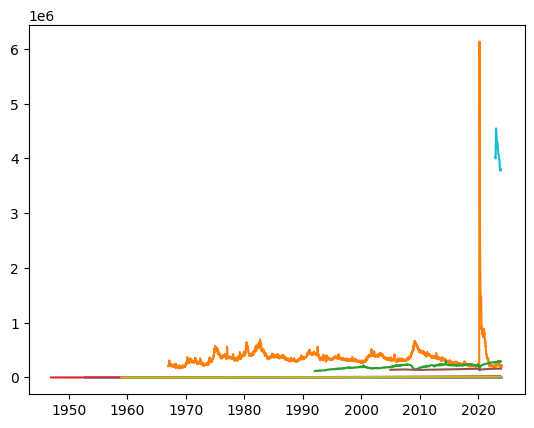

In [4]:
yo = MacroFactors()